In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

## Higher-level abstractions

* Structured layers: ``torch.nn.module``
* Standard optimizers ``torch.optim`` 
* Datasets and data loaders: 

## Motivation

Let us define a linear model manually

$$ f: \mathbb{R}^{10} \rightarrow \mathbb{R}^{4} := Wx + b $$

In [2]:
nx = 10; ny = 4;
W = torch.randn(ny, nx, requires_grad=True)
b = torch.randn(ny, requires_grad=True)
x = torch.randn(nx)

def lin(W, b, x):
    y = W @ x + b
    return y 

x.shape, lin(W, b, x).shape

(torch.Size([10]), torch.Size([4]))

The above only work on a single instance of size $n_x$. For a batch, we need something else:

In [3]:
batch_size = 32; batch_x = torch.randn(batch_size, nx)

def batched_lin(W, b, batch_x):
    y =  batch_x @ W.T + b
    return y

batch_x.shape, batched_lin(W, b, batch_x).shape

(torch.Size([32, 10]), torch.Size([32, 4]))

It is much easier to use the built-in PyTorch Linear module

In [4]:
lin = nn.Linear(in_features=nx, out_features=ny, bias=True) # bias=True means we have the b term (truly linear, not affine)
lin.weight.shape, lin.bias.shape # W.T and b

(torch.Size([4, 10]), torch.Size([4]))

The module can be called with data, either a single instance or a batch

In [5]:
lin(x).shape, lin(batch_x).shape

(torch.Size([4]), torch.Size([32, 4]))

Advantages of the ``nn.Linear`` module

* Less code
* Instantiates the parameters and keep them in order
* Handles single instances and batches seamlessly

The biggest advantages are for more complex models! 

## Model construction

We can build more complex models by subclassing ``nn.Module``. 

Let us define a MLP with 10 inputs, 4 outputs, 100 hidden units:

$$f: \mathbb{R}^{10} \rightarrow \mathbb{R}^{4} := W_2 \tanh (W_1 x + b_1) + b_2$$

$$
W_1 \in \mathbb{R}^{100 \times 10}, b_1 \in \mathbb{R}^{100}, W_2 \in \mathbb{R}^{4 \times 100}, b_2 \in \mathbb{R}^{10},
$$

In [6]:
class MLP(nn.Module):
    def __init__(self, in_size, out_size, hidden_size):
        super().__init__()
        self.lin1 = nn.Linear(in_size, hidden_size)
        self.activation = nn.Tanh()
        self.lin2 = nn.Linear(hidden_size, out_size)

    def forward(self, x):
        x = self.activation(self.lin1(x)) # hidden layer
        x = self.lin2(x) # output layer
        return x

In [7]:
mlp = MLP(in_size=10, out_size=4, hidden_size=100); mlp

MLP(
  (lin1): Linear(in_features=10, out_features=100, bias=True)
  (activation): Tanh()
  (lin2): Linear(in_features=100, out_features=4, bias=True)
)

In [8]:
x.shape, batch_x.shape

(torch.Size([10]), torch.Size([32, 10]))

In [9]:
mlp(x).shape, mlp(batch_x).shape

(torch.Size([4]), torch.Size([32, 4]))

## Example

The same of the previous exercise: data from

$$ y = 2 \sin(3x) - 3 \cos(7x) $$

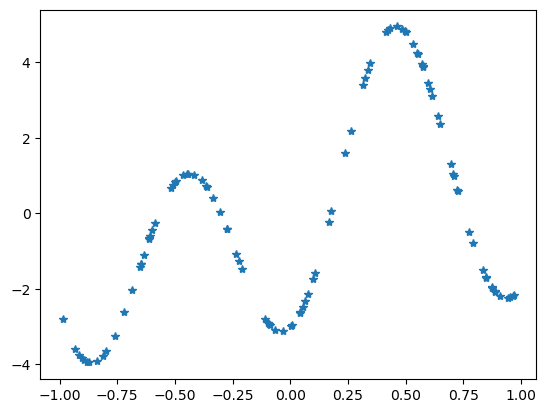

In [10]:
nx = 1; ny = 1; a = -1; b = 1; n_samples = 100; sigma_e = 0.1
x_train = a + torch.rand((n_samples, 1))*(b - a)
y_train = 2*torch.sin(3*x_train)  - 3*torch.cos(7*x_train)
plt.plot(x_train, y_train, "*");

In [11]:
mlp = MLP(in_size=1, out_size=1, hidden_size=16); mlp

MLP(
  (lin1): Linear(in_features=1, out_features=16, bias=True)
  (activation): Tanh()
  (lin2): Linear(in_features=16, out_features=1, bias=True)
)

In [12]:
mlp(x_train).shape

torch.Size([100, 1])

## Training with ``nn.Module``

In [13]:
mlp = MLP(in_size=1, out_size=1, hidden_size=16)
LOSS = []
for _ in range(10_000):
    y_hat = mlp(x_train)
    loss = torch.mean((y_train - y_hat)**2)
    loss.backward()
    # manual gradient descent
    for p in mlp.parameters():
        p.data -= 0.01 * p.grad
        p.grad.zero_() # clears the .grad variable
    LOSS.append(loss.item())

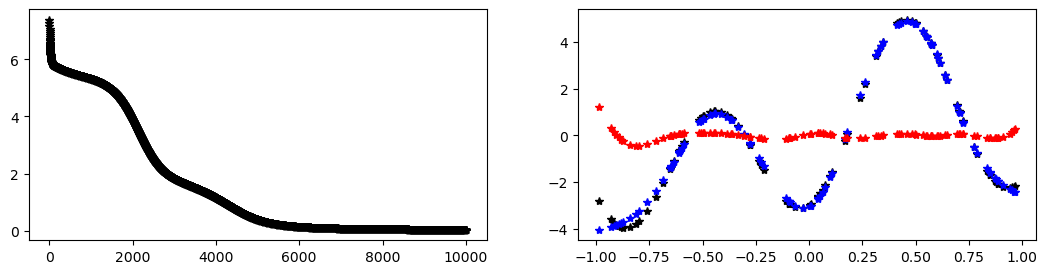

In [14]:
y_hat = mlp(x_train).detach() 
fig, ax = plt.subplots(1, 2, figsize=(13, 3))
ax[0].plot(LOSS, "k*")
ax[1].plot(x_train, y_train, "k*")
ax[1].plot(x_train, y_hat, "b*")
ax[1].plot(x_train, y_train - y_hat, "r*");

## Training with ``nn.Module`` and PyTorch optimizers

* Plain gradient descent is not the best algorithm. Adam, AdamW, L-BFGS are often more effective
* It is boring and error-prone to implement optimizers from scratch
* PyTorch provides standard optimizers in ``torch.optim``

In [15]:
mlp = MLP(in_size=1, out_size=1, hidden_size=16)
opt = torch.optim.Adam(mlp.parameters(), lr=1e-3) # ready-made optimizers
LOSS = []
for _ in range(10_000):
    opt.zero_grad() # cleans gradients accumulated from previous iterations
    y_hat = mlp(x_train)
    loss = torch.mean((y_train - y_hat)**2)
    loss.backward() # gradient computation
    opt.step() # optimization step
    LOSS.append(loss.item())

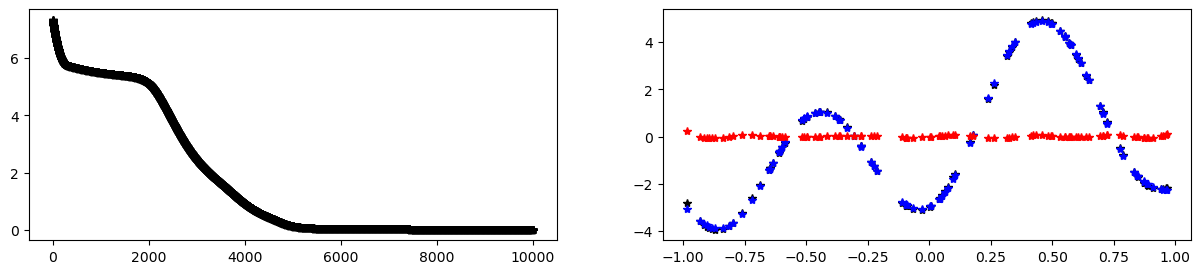

In [16]:
y_hat = mlp(x_train).detach() 
fig, ax = plt.subplots(1, 2, figsize=(15, 3))
ax[0].plot(LOSS, "k*")
ax[1].plot(x_train, y_train, "k*")
ax[1].plot(x_train, y_hat, "b*")
ax[1].plot(x_train, y_train - y_hat, "r*");

## Datasets and data loaders

In the previous examples, the dataset was very simple and we trained on the whole dataset

* It is more common to train with (mini)batches
* Sometimes the data extraction logic is complex
* PyTorch classes ``torch.utils.data.Dataset`` ``torch.utils.data.DataLoaded`` facilitate data handling

We use a larger dataset to make things look a little bit more realistic:

In [17]:
x_train_long = a + torch.rand((100*n_samples, 1))*(b - a)
y_train_long = 2*torch.sin(3*x_train_long)  - 3*torch.cos(7*x_train_long)
x_train_long.shape, y_train_long.shape

(torch.Size([10000, 1]), torch.Size([10000, 1]))

## Dataset

The PyTorch dataset is meant to hide the complexity of retreiving training instances

In [18]:
from torch.utils.data import Dataset, TensorDataset

class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    # number of training instances
    def __len__(self):
        return len(self.x)

    # logit to access a single instance.
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [19]:
ds = MyDataset(x_train_long, y_train_long)
ds[0] # a simple input-output pair

(tensor([-0.9554]), tensor([-3.3019]))

In this case the ``__getitem__`` logic is trivial. In general, it could hide reading an image/video from file, accessing a database, generating synthetic data, ...

In [20]:
ds = TensorDataset(x_train_long, y_train_long) # this built-in DataSet is equivalent to MyDataset
ds[0]

(tensor([-0.9554]), tensor([-3.3019]))

### Data Loader

The ``DataLoader`` takes in a ``Dataset`` and provides an iterator over the batches

In [21]:
from torch.utils.data import DataLoader

ds = TensorDataset(x_train_long, y_train_long)
dl = DataLoader(ds, batch_size=32, shuffle=True)

In [22]:
batch_x, batch_y = next(iter(dl)) # the data loader is a Python iterable
batch_x.shape, batch_y.shape # a batch of training instances, ready for a training step!

(torch.Size([32, 1]), torch.Size([32, 1]))

In particular, we can iterate it with a for loop, where iterative optimization will run. We typically pass through the dataset a number of *epochs*.

In [23]:
for epoch in range(10):
    for (batch_x, batch_y) in dl:
        pass # actually, do a training step here!

## Training Loop

Finally, this canonical training code in PyTorch!

In [24]:
ds = TensorDataset(x_train_long, y_train_long)
dl = DataLoader(ds, batch_size=128, shuffle=True)
mlp = MLP(in_size=1, out_size=1, hidden_size=16)
opt = torch.optim.Adam(mlp.parameters(), lr=1e-2)

LOSS = []
for epoch in range(40): # 1 epoch is a "pass" through the whole training dataset
    for (batch_x, batch_y) in dl:

        opt.zero_grad()
        batch_y_hat = mlp(batch_x)
        loss = torch.mean((batch_y - batch_y_hat)**2)
        
        loss.backward() # gradient computation
        opt.step() # optimization step
        LOSS.append(loss.item())

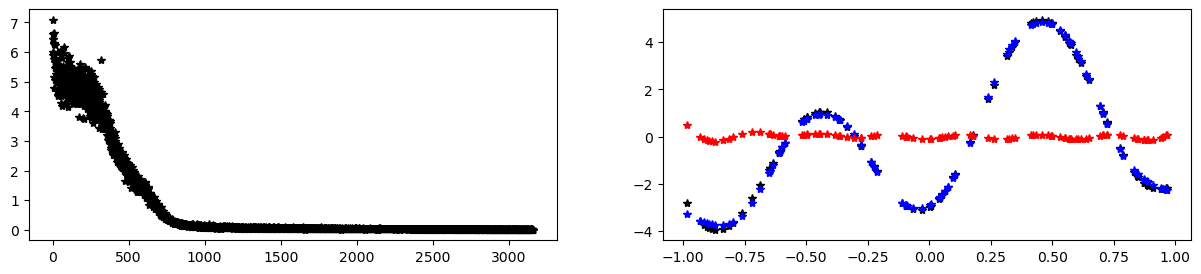

In [25]:
with torch.no_grad():
    y_hat = mlp(x_train)
    
fig, ax = plt.subplots(1, 2, figsize=(15, 3))
ax[0].plot(LOSS, "k*")
ax[1].plot(x_train, y_train, "k*")
ax[1].plot(x_train, y_hat, "b*")
ax[1].plot(x_train, y_train - y_hat, "r*");

# The Functional API


PyTorch "hide" parameters within modules. Often convenient, but limiting/awkward for some advanced use cases

In [26]:
mlp

MLP(
  (lin1): Linear(in_features=1, out_features=16, bias=True)
  (activation): Tanh()
  (lin2): Linear(in_features=16, out_features=1, bias=True)
)

In [27]:
batch_x = torch.randn(batch_size, 1); batch_y = torch.randn(batch_size, 1); 
mlp(batch_x).shape

torch.Size([32, 1])

We can optionally call modules as functions. First, extract the parameters to a dictionary of tensors:

In [28]:
params = dict(mlp.named_parameters()) # dictionary parmeter_name : parameter_value

Then, call them with ``torch.func.functional_call``

In [29]:
batch_y_pred = torch.func.functional_call(mlp, params, batch_x); batch_y_pred.shape

torch.Size([32, 1])

# The Functional API

We may then write the loss as a differentiable function...

In [30]:
def loss_fn(params, x, y):
    y_pred = torch.func.functional_call(mlp, params, x);
    loss = torch.mean((y - y_pred)**2)
    return loss
    
loss_fn(params, batch_x, batch_y)

tensor(7.7343, grad_fn=<MeanBackward0>)

and the loss gradient as a differentiable function...

In [31]:
grad_fn = torch.func.grad(loss_fn, argnums=0)
grads = grad_fn(params, batch_x, batch_y) # dictionary parameter_name: gradient_value
grads

{'lin1.weight': tensor([[-0.0726],
         [-0.1030],
         [ 0.2720],
         [ 0.0738],
         [-0.1991],
         [ 0.4821],
         [ 0.7868],
         [-0.8439],
         [ 0.1747],
         [ 0.8863],
         [ 0.9338],
         [ 0.0889],
         [ 1.0415],
         [ 0.8642],
         [ 0.6444],
         [ 0.1079]], grad_fn=<TBackward0>),
 'lin1.bias': tensor([-0.5311,  0.3554, -0.3200, -0.2605,  0.2677,  1.0131, -0.7651,  0.8149,
         -1.3581, -0.8450, -0.9382, -0.3280, -1.0716, -0.8983, -0.6680, -0.3894],
        grad_fn=<ViewBackward0>),
 'lin2.weight': tensor([[-0.5677, -0.0750, -0.2209, -0.0927,  0.3035,  0.6727,  0.8752, -0.8846,
           0.0480,  0.8788,  0.8953, -0.0591,  0.9042,  0.8822,  0.8642,  0.0383]],
        grad_fn=<TBackward0>),
 'lin2.bias': tensor([-2.3734], grad_fn=<ViewBackward0>)}

and the parameter update as a differentiable function!

In [32]:
def gd_update_fn(p, x, y, alpha):
    grad_fn = torch.func.grad(loss_fn, argnums=0)
    g = grad_fn(p, x, y)
    p_upd = {k: p[k] - alpha * g[k] for k in p.keys()}
    return p_upd

In [33]:
alpha = torch.tensor(0.1)
params_updated = gd_update_fn(params, batch_x, batch_y, alpha) # parameters updated by gradient descent!

The function ``gd_update_fn`` is a gradient descent step, and it is still differentiable with respect to all its arguments.

This allows one to optimize (parameterized) algorithms, e.g.
* learn the best initialization for gradient descent (MAML)
* learn the best learning rate by gradient descent

Learning algorithms is known as **meta learning**, aka learning to learn.

## The Functional API

Another super useful tool in the functional API is ``vmap``, which allows you to vectorize functions.

In [34]:
n_hidden = 16
params_init = {
    "W1": torch.randn(n_hidden, nx, requires_grad=True),
    "b1": torch.randn(n_hidden, requires_grad=True),
    "W2": torch.randn(ny, n_hidden, requires_grad=True),
    "b2": torch.randn(ny, requires_grad=True)
}

def nn(params, x):
    # shape of x: (nx,)
    z = torch.tanh(params["W1"] @ x + params["b1"])
    y = params["W2"] @ z + params["b2"]
    return y

In [35]:
batched_nn = torch.func.vmap(nn, in_dims=(None, 0)) # vectorize with respect to the second argument (x) shape of x: (batch_size, nx)

This allows one to define functions on a single example, without the need of tricky linear algebra/broadcasting tricks

In [36]:
# We can "vectorize" the nn function with linear algebra and broadcasting tricks
def batched_nn(params, x):
    z = torch.sigmoid(x @ params["W1"].T + params["b1"])
    y = z @ params["W2"].T + params["b2"]
    return y